# Project 4: <br>Using Computer Vision to Detect/Determine Pneumonia Using Lung X-Ray Images 

## Business Problem

Due to a shortage of staff and doctors through COVID-19, the St.Jude Children's Hospital wants to use A.I. to diagnose pneumonia through x-ray images of children's lungs. The goal of this project is to use convolution neural network for computer vision to detect pneumonia from x-ray images. 

In [1]:
import tensorflow as tf
tf.random.set_seed(609)
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import FalsePositives

import numpy as np
np.random.seed(817)
import os

from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

### Preprocessing

Because the size of the validation set provided was too small, the validation data set had to be split from the test set. To make sure that all data sets had the same batch size and target size, I created two objects to represent those numbers. When using the ImageDataGenerator, it was important to rescale each pixel as their values were represented in a RGB value that ranged from 0 to 255 so that all RGB values were represented between 0 and 1.

In [2]:
train_data_dir= 'data/train'
test_data_dir='data/test'
oversample_dir='data/oversample'

In [3]:
# When the batch size was reduced to 64, the results did not come out well
batch_batch=128 
target=(32,32)

In [4]:
train_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_data_dir, 
    target_size=target, 
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)

test_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_set=test_generator.flow_from_directory(
    test_data_dir, 
    target_size=target,
    subset='training',
    class_mode='binary',
    batch_size=batch_batch, 
    seed=369)
val_set = test_generator.flow_from_directory(
    test_data_dir, 
    target_size=target,
    subset='validation',
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)

Found 5216 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [5]:
def get_full_xy_from_gen(train_set):
    """Loops through an image data generator dataset
    and concatenates all batches of X and y samples.
    source:https://colab.research.google.com/drive/1HdM3ckzdL96BuGhAwnXwI0WllTGmG0uq#scrollTo=Pf_zrXuQFMVA
    written by James Irving (got permission from himself)
    """
    from tqdm import trange    
    Xs,ys= [],[]

    for i in trange(len(train_set)):
        X_,y_ = next(train_set)
        Xs.append(X_)
        ys.append(y_)
        
    X = np.concatenate(Xs,axis=0)
    y = np.concatenate(ys,axis=0)
    print(f"Final X data.shape: {X.shape}")
    print(f"Final y data.shape: {y.shape}")
    return X,y

In [6]:
X_train,y_train = get_full_xy_from_gen(train_set)
X_test,y_test = get_full_xy_from_gen(test_set)
X_val,y_val = get_full_xy_from_gen(val_set)

  0%|          | 0/4 [00:00<?, ?it/s]

Final X data.shape: (5216, 32, 32, 3)
Final y data.shape: (5216,)


  0%|          | 0/1 [00:00<?, ?it/s]

Final X data.shape: (500, 32, 32, 3)
Final y data.shape: (500,)


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]

Final X data.shape: (124, 32, 32, 3)
Final y data.shape: (124,)


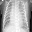

In [110]:
array_to_img(X_train[0])

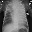

In [104]:
array_to_img(X_train[1])

In [7]:
pd.Series(train_set.labels).value_counts(1)

1    0.742906
0    0.257094
dtype: float64

In [8]:
## Get the array of weights for each unique class
weights= compute_class_weight(
           'balanced',
            np.unique(y_train),
            y_train)
weights

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[1. 1. 1. ... 1. 1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([1.9448173 , 0.67303226])

In [9]:
## Turn the weights into a dict with the class name as the key
weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [10]:
# Shows what classifications there are
train_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

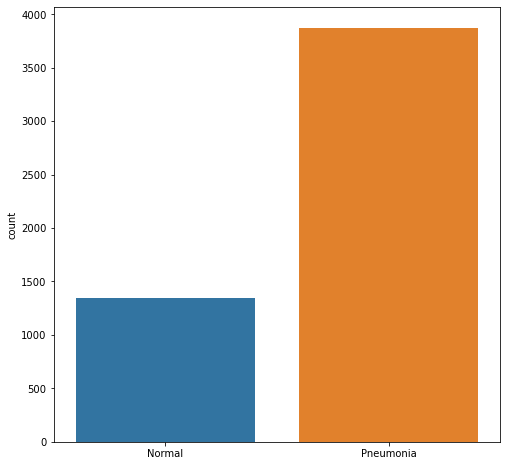

In [96]:
# A bargraph showing the number of images per classification
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x=pd.Series(train_set.labels).map({0: 'Normal', 1: 'Pneumonia'}))

As can be seen, there is a large difference between the number of normal x-ray images and pneumonia x-ray images.

# Model Training

## CNN (Convolution Neural Network)

For computer vision, using the convolution neural network is recommended. For each iteration, the goal is to decrease the number of layers used while achieving a high precision for detecting pneumonia.<br>
Each iteration will have two versions: one that monitors validation loss and another that monitors validation accuracy to stop the modeling process. 


### Iteration #1

In [12]:
# Calling tf.config.run_functions_eagerly(True) will make all invocations of tf.function run eagerly 
# instead of running as a traced graph function.
# tf.config.run_functions_eagerly(True)

In [13]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dropout(.5))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])
base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 64)          3

In [14]:
# Function to show the model's loss and accuracy graph as well as the confusion matrix
def model_score(model, iteration, X_test, y_test):
    model_df=pd.DataFrame(model.history)
    
    loss_plt=model_df[[col for col in model_df.columns if 'loss' in col]].plot(marker='.')
    loss_plt.set(xlabel='Epoch',ylabel='MSE', title='Loss')
    plt.show()

    accuracy_plt=model_df[[col for col in model_df.columns if 'acc' in col]].plot(marker='.')
    accuracy_plt.set(xlabel='Epoch',ylabel='Accuracy', title='Accuracy')
    plt.show()
    
    test_pred = iteration.predict(X_test).flatten()
    test_pred=np.round(test_pred, 0)
    
    conf_matrix=metrics.confusion_matrix(y_test, test_pred, normalize='true')
    sns.heatmap(conf_matrix,annot= True, cmap='Blues', linewidths=.3)
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(metrics.classification_report(y_test, test_pred))

In [15]:
# Creating callbacks for different monitors. 
stop_early_loss = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
stop_early_acc_binary = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=1, restore_best_weights=True)

reduce_lr_loss=ReduceLROnPlateau(monitor= 'val_loss', patience=3, factor=.2, min_lr=.001)
reduce_lr_acc_binary=ReduceLROnPlateau(monitor= 'val_binary_accuracy', patience=3, factor=.2, min_lr=.001)

callback_loss=[stop_early_loss, reduce_lr_loss]
callback_acc_binary = [stop_early_acc_binary, reduce_lr_acc_binary]

In [16]:
model1_loss=base.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
41/41 [==============================] - 16s 371ms/step - loss: 0.6935 - binary_accuracy: 0.5372 - val_loss: 0.6946 - val_binary_accuracy: 0.3710
Epoch 2/30
41/41 [==============================] - 15s 368ms/step - loss: 0.6933 - binary_accuracy: 0.3303 - val_loss: 0.6920 - val_binary_accuracy: 0.6290
Epoch 3/30
41/41 [==============================] - 15s 373ms/step - loss: 0.6920 - binary_accuracy: 0.5679 - val_loss: 0.6888 - val_binary_accuracy: 0.6290
Epoch 4/30
41/41 [==============================] - 15s 373ms/step - loss: 0.6932 - binary_accuracy: 0.6844 - val_loss: 0.6921 - val_binary_accuracy: 0.6613
Epoch 5/30
41/41 [==============================] - 15s 371ms/step - loss: 0.6002 - binary_accuracy: 0.6221 - val_loss: 0.4056 - val_binary_accuracy: 0.7903
Epoch 6/30
41/41 [==============================] - 15s 369ms/step - loss: 0.

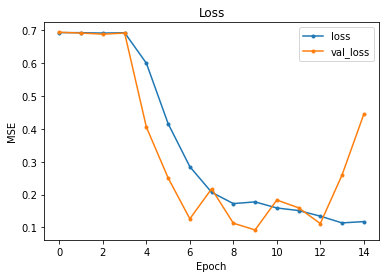

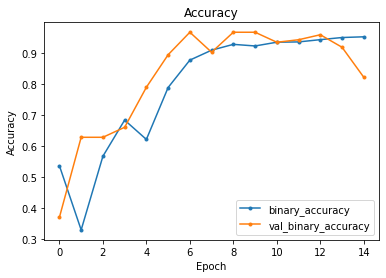

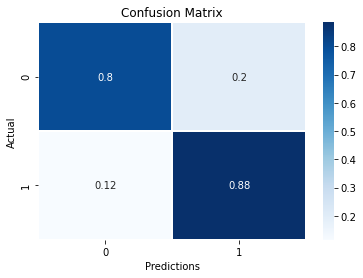

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81       188
         1.0       0.88      0.88      0.88       312

    accuracy                           0.85       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.85      0.85      0.85       500



In [17]:
model_score(model1_loss, base, X_test, y_test)

Our first model actually performed much better than expected. The validation loss and accuracy graphs are well fitted, but there seems to be some over-fitting. The confusion matrix shows decently high recall scores for both true positive and true negative. 

 comment on each model/version of what happened, what went wrong, and how to address/fix this issue

In [18]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dropout(.5))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [19]:
model1_acc=base.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 16s 372ms/step - loss: 0.6934 - binary_accuracy: 0.4816 - val_loss: 0.6969 - val_binary_accuracy: 0.3710
Epoch 2/30
41/41 [==============================] - 15s 369ms/step - loss: 0.6419 - binary_accuracy: 0.5587 - val_loss: 0.1987 - val_binary_accuracy: 0.9355
Epoch 3/30
41/41 [==============================] - 16s 379ms/step - loss: 0.3544 - binary_accuracy: 0.8487 - val_loss: 0.3135 - val_binary_accuracy: 0.8387
Epoch 4/30
41/41 [==============================] - 15s 356ms/step - loss: 0.2253 - binary_accuracy: 0.9105 - val_loss: 0.2635 - val_binary_accuracy: 0.8468
Epoch 5/30
41/41 [==============================] - 15s 361ms/step - loss: 0.1974 - binary_accuracy: 0.9195 - val_loss: 0.4980 - val_binary_accuracy: 0.7823
Epoch 6/30
41/41 [==============================] - 15s 373ms/step - loss: 0.1551 - binary_accuracy: 0.9400 - val_loss: 0.1586 - val_binary_accuracy: 0.9355
Epoch 7/30
41/41 [==============================] - 15s 36

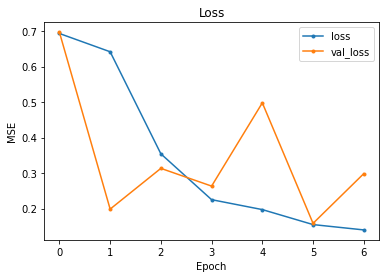

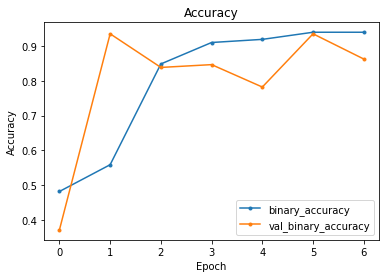

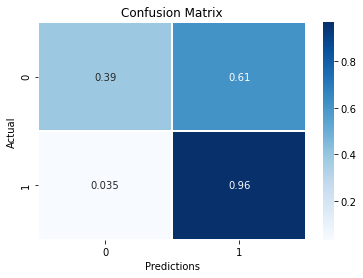

              precision    recall  f1-score   support

         0.0       0.87      0.39      0.54       188
         1.0       0.72      0.96      0.83       312

    accuracy                           0.75       500
   macro avg       0.80      0.68      0.68       500
weighted avg       0.78      0.75      0.72       500



In [20]:
model_score(model1_acc, base, X_test, y_test) 

The recall rate for predicting true positives, or pneumonia patients, are high; however, we can see that it does a very poor job in predicting true negatives resulting in a high number of false positives. This could lead to many patients being treated for pneumonia resulting in unnecessary medication bills, and in some cases being treated for the wrong disease. 
talk about what i said in the presentation in terms of medical?

### Iteration #2

In [21]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dropout(.5))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [22]:
iter_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 64)         

In [23]:
model2_loss=iter_2.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 17s 399ms/step - loss: 0.6939 - binary_accuracy: 0.5454 - val_loss: 0.6891 - val_binary_accuracy: 0.6613
Epoch 2/30
41/41 [==============================] - 16s 392ms/step - loss: 0.5198 - binary_accuracy: 0.7278 - val_loss: 0.4348 - val_binary_accuracy: 0.7903
Epoch 3/30
41/41 [==============================] - 16s 390ms/step - loss: 0.2347 - binary_accuracy: 0.9078 - val_loss: 0.7113 - val_binary_accuracy: 0.7339
Epoch 4/30
41/41 [==============================] - 16s 401ms/step - loss: 0.1886 - binary_accuracy: 0.9218 - val_loss: 0.3774 - val_binary_accuracy: 0.8548
Epoch 5/30
41/41 [==============================] - 17s 408ms/step - loss: 0.1527 - binary_accuracy: 0.9398 - val_loss: 0.6600 - val_binary_accuracy: 0.7984
Epoch 6/30
41/41 [==============================] - 17s 405ms/step - loss: 0.1209 - binary_accuracy: 0.9513 - val_loss: 0.5619 - val_binary_accuracy: 0.7903
Epoch 7/30
41/41 [==============================] - 17s 42

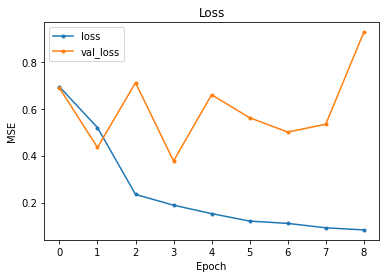

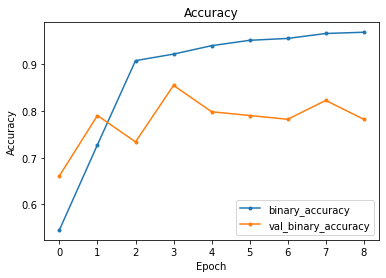

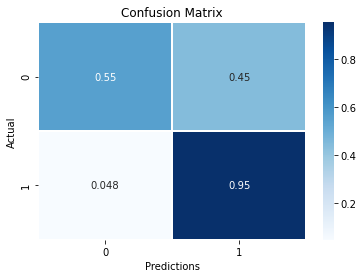

              precision    recall  f1-score   support

         0.0       0.87      0.55      0.68       188
         1.0       0.78      0.95      0.86       312

    accuracy                           0.80       500
   macro avg       0.83      0.75      0.77       500
weighted avg       0.82      0.80      0.79       500



In [24]:
model_score(model2_loss,iter_2, X_test, y_test)

Again, our model was good at diagnosing pneumonia patients with a recall rate of 95%. While it has improved in distinguishing between normal and pneumonia patients, it still has a very high false positive rate. The validation loss and accuracy graph does not fit well, which could be explained by the high false positive rate. 

In [25]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dropout(.5))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [26]:
model2_acc=iter_2.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 17s 409ms/step - loss: 0.6939 - binary_accuracy: 0.6518 - val_loss: 0.6917 - val_binary_accuracy: 0.6290
Epoch 2/30
41/41 [==============================] - 16s 395ms/step - loss: 0.6932 - binary_accuracy: 0.6683 - val_loss: 0.6923 - val_binary_accuracy: 0.6290
Epoch 3/30
41/41 [==============================] - 16s 398ms/step - loss: 0.6931 - binary_accuracy: 0.6933 - val_loss: 0.6875 - val_binary_accuracy: 0.8710
Epoch 4/30
41/41 [==============================] - 16s 398ms/step - loss: 0.4781 - binary_accuracy: 0.7822 - val_loss: 0.1294 - val_binary_accuracy: 0.9355
Epoch 5/30
41/41 [==============================] - 16s 396ms/step - loss: 0.2252 - binary_accuracy: 0.9072 - val_loss: 0.6141 - val_binary_accuracy: 0.7903
Epoch 6/30
41/41 [==============================] - 17s 404ms/step - loss: 0.1680 - binary_accuracy: 0.9337 - val_loss: 0.1984 - val_binary_accuracy: 0.9032
Epoch 7/30
41/41 [==============================] - 16s 40

Our model has improved significantly in this version of the iteration. It is now able to identify 87% of normal patients, but its ability to diagnose pneumonia patients has decreased by more than 10%. The validation loss and accuracy graph fits much better which could explain the similar recall scores for true positive and true negative.  

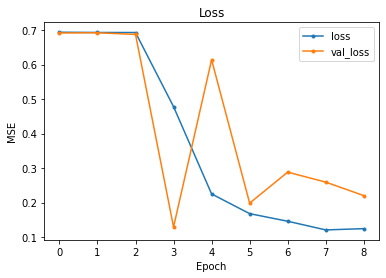

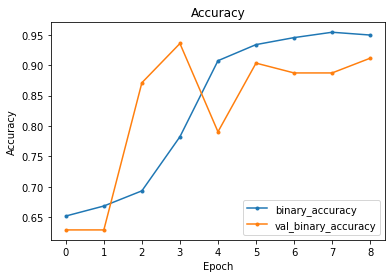

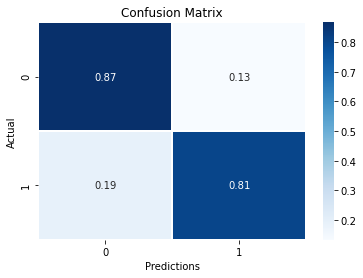

              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79       188
         1.0       0.91      0.81      0.86       312

    accuracy                           0.83       500
   macro avg       0.82      0.84      0.82       500
weighted avg       0.84      0.83      0.83       500



In [27]:
model_score(model2_acc, iter_2, X_test, y_test) #dropout added

### Iteration #3

In [28]:
iter3=models.Sequential()

iter3.add(Conv2D(32, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(128, (3,3), activation='relu'))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dropout(.5))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [29]:
iter3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 10, 64)        73792     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 3, 3, 32)         

In [30]:
model3_loss=iter3.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 6s 133ms/step - loss: 0.6574 - binary_accuracy: 0.5686 - val_loss: 0.4629 - val_binary_accuracy: 0.8145
Epoch 2/30
41/41 [==============================] - 5s 128ms/step - loss: 0.4510 - binary_accuracy: 0.7789 - val_loss: 0.3447 - val_binary_accuracy: 0.8226
Epoch 3/30
41/41 [==============================] - 5s 127ms/step - loss: 0.3436 - binary_accuracy: 0.8416 - val_loss: 0.2238 - val_binary_accuracy: 0.9113
Epoch 4/30
41/41 [==============================] - 5s 132ms/step - loss: 0.2594 - binary_accuracy: 0.8932 - val_loss: 0.1755 - val_binary_accuracy: 0.9355
Epoch 5/30
41/41 [==============================] - 6s 147ms/step - loss: 0.1957 - binary_accuracy: 0.9245 - val_loss: 0.3076 - val_binary_accuracy: 0.8387
Epoch 6/30
41/41 [==============================] - 6s 143ms/step - loss: 0.2017 - binary_accuracy: 0.9197 - val_loss: 0.1504 - val_binary_accuracy: 0.9435
Epoch 7/30
41/41 [==============================] - 6s 144ms/ste

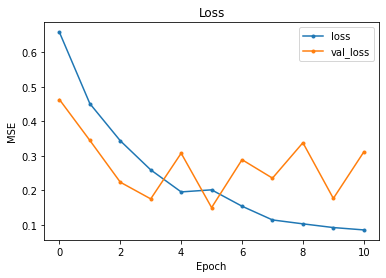

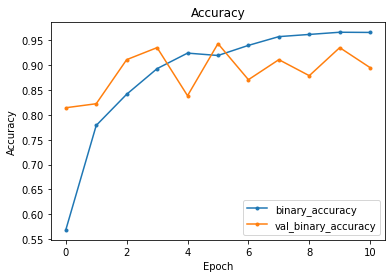

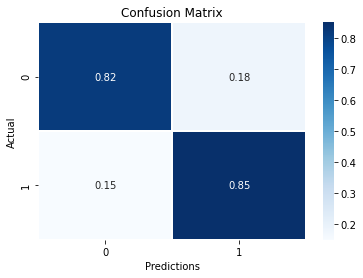

              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79       188
         1.0       0.89      0.85      0.87       312

    accuracy                           0.84       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.84      0.84      0.84       500



In [31]:
model_score(model3_loss,iter3, X_test, y_test) 


Not much has changed compared to the second iteration using validation accuracy as the stopping metric. It is able to identify pneumonia patients slightly better, but it does a worse job of discerning normal patients. From the iterations so far, there has been a trend where the better the validation loss and validation accuracy graphs fit, the more similar the recall rate is between the true positive and true negative. 

In [32]:
iter3=models.Sequential()

iter3.add(Conv2D(32, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(128, (3,3), activation='relu'))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dropout(.5))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [33]:
model3_acc=iter3.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 6s 145ms/step - loss: 0.6814 - binary_accuracy: 0.5681 - val_loss: 0.5601 - val_binary_accuracy: 0.8790
Epoch 2/30
41/41 [==============================] - 6s 144ms/step - loss: 0.4518 - binary_accuracy: 0.7893 - val_loss: 0.2139 - val_binary_accuracy: 0.9435
Epoch 3/30
41/41 [==============================] - 6s 148ms/step - loss: 0.2872 - binary_accuracy: 0.8854 - val_loss: 0.2979 - val_binary_accuracy: 0.8387
Epoch 4/30
41/41 [==============================] - 6s 147ms/step - loss: 0.2305 - binary_accuracy: 0.9107 - val_loss: 0.2069 - val_binary_accuracy: 0.9274
Epoch 5/30
41/41 [==============================] - 6s 145ms/step - loss: 0.1879 - binary_accuracy: 0.9254 - val_loss: 0.2396 - val_binary_accuracy: 0.8952
Epoch 6/30
41/41 [==============================] - 6s 141ms/step - loss: 0.1556 - binary_accuracy: 0.9396 - val_loss: 0.3687 - val_binary_accuracy: 0.8468
Epoch 7/30
41/41 [==============================] - 5s 131ms/ste

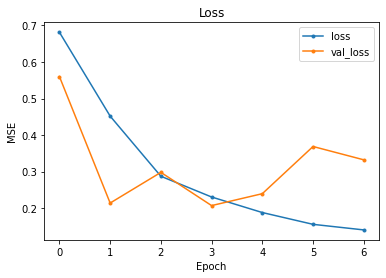

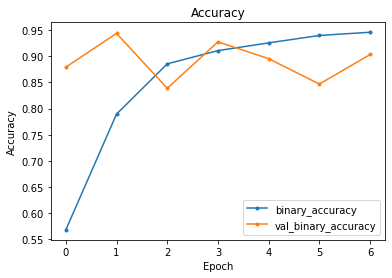

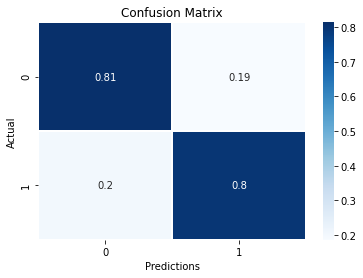

              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76       188
         1.0       0.88      0.80      0.84       312

    accuracy                           0.80       500
   macro avg       0.79      0.81      0.80       500
weighted avg       0.81      0.80      0.81       500



In [34]:
model_score(model3_acc,iter3, X_test, y_test) #32 64 128 64 32 no dense 32

The recall rate for the true positive and true negative are decent, but performed slightly worse than the previous version of the same iteration. The graphs also does not fit as well and there seems to be decent amount of over-fitting in the validation accuracy graph.

### Iteration #4

Removed much of the layers and maxpooling2d, changed metrics to binary accuracy 

In [35]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dropout(.5))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [36]:
model4_loss=iter4.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 3s 54ms/step - loss: 0.5398 - binary_accuracy: 0.7339 - val_loss: 0.3266 - val_binary_accuracy: 0.8629
Epoch 2/30
41/41 [==============================] - 2s 51ms/step - loss: 0.2928 - binary_accuracy: 0.8779 - val_loss: 0.2604 - val_binary_accuracy: 0.8790
Epoch 3/30
41/41 [==============================] - 2s 51ms/step - loss: 0.2009 - binary_accuracy: 0.9231 - val_loss: 0.2574 - val_binary_accuracy: 0.8871
Epoch 4/30
41/41 [==============================] - 2s 52ms/step - loss: 0.1775 - binary_accuracy: 0.9283 - val_loss: 0.2886 - val_binary_accuracy: 0.8790
Epoch 5/30
41/41 [==============================] - 2s 54ms/step - loss: 0.1511 - binary_accuracy: 0.9388 - val_loss: 0.3446 - val_binary_accuracy: 0.8710
Epoch 6/30
41/41 [==============================] - 2s 53ms/step - loss: 0.1440 - binary_accuracy: 0.9436 - val_loss: 0.3687 - val_binary_accuracy: 0.8548
Epoch 7/30
41/41 [==============================] - 2s 54ms/step - los

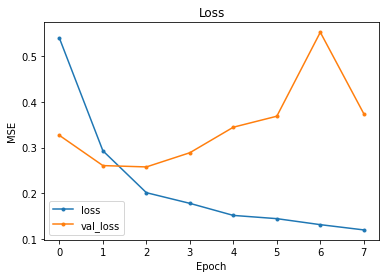

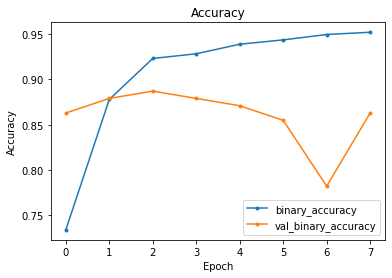

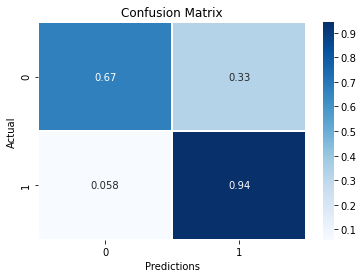

              precision    recall  f1-score   support

         0.0       0.88      0.67      0.76       188
         1.0       0.83      0.94      0.88       312

    accuracy                           0.84       500
   macro avg       0.85      0.81      0.82       500
weighted avg       0.84      0.84      0.83       500



In [37]:
model_score(model4_loss, iter4, X_test, y_test) #64 32

Again, the graphs fit very poorly, but compared to the second version of the first iteration, the recall rate for true negatives is far better even though the validation loss and validation accuracy graphs do not fit well. 

In [38]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dropout(.5))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [39]:
model4_acc=iter4.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 3s 54ms/step - loss: 0.5919 - binary_accuracy: 0.6499 - val_loss: 0.4133 - val_binary_accuracy: 0.7500
Epoch 2/30
41/41 [==============================] - 2s 51ms/step - loss: 0.3388 - binary_accuracy: 0.8577 - val_loss: 0.2114 - val_binary_accuracy: 0.9032
Epoch 3/30
41/41 [==============================] - 2s 53ms/step - loss: 0.2215 - binary_accuracy: 0.9132 - val_loss: 0.3909 - val_binary_accuracy: 0.7903
Epoch 4/30
41/41 [==============================] - 2s 54ms/step - loss: 0.1806 - binary_accuracy: 0.9296 - val_loss: 0.3874 - val_binary_accuracy: 0.8145
Epoch 5/30
41/41 [==============================] - 2s 54ms/step - loss: 0.1687 - binary_accuracy: 0.9342 - val_loss: 0.4672 - val_binary_accuracy: 0.7984
Epoch 6/30
41/41 [==============================] - 2s 52ms/step - loss: 0.1508 - binary_accuracy: 0.9446 - val_loss: 0.3098 - val_binary_accuracy: 0.8629
Epoch 7/30
41/41 [==============================] - 2s 53ms/step - los

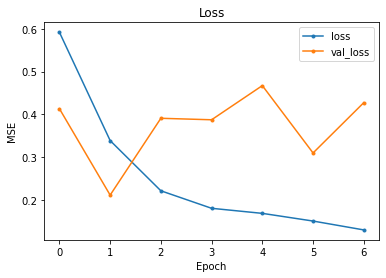

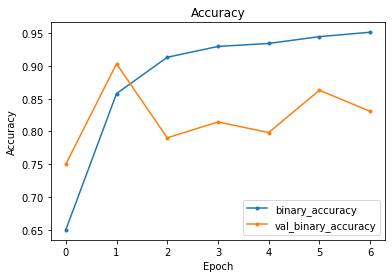

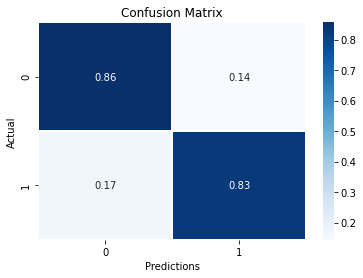

              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       188
         1.0       0.91      0.83      0.86       312

    accuracy                           0.84       500
   macro avg       0.83      0.84      0.83       500
weighted avg       0.85      0.84      0.84       500



In [40]:
model_score(model4_acc, iter4, X_test, y_test)#64 32

This version of this iteration was slightly puzzling because while the validation loss and validation accuracy graphs do not fit well, the recall rate for true positives and true negatives are decently high and their values are very similar.

## Oversampling
After running the tests, we will try using the oversampling method to even the weight difference between normal images and pneumonia images. Initially, I planned on using the version that had the best results of each iteration, whether it be using the validation loss or validation accuracy as the stopping metric. However upon further testing, versions that validation loss seemed to heavily over-fit, so both versions of the iterations were added. 
<br> 
When using CNN oversampling is one of the most recommended methods of evening out the weight differences for binary data. The images in the normal category consists of two copies of normal training image data and one from the normal test image data. Our goal is to be able to increase the recall rate of true positives and true negatives and decreased the overall number of misdiagnosis.<br>
Just as we created the test_set from the test folder at the beginning, we will create an oversample set that I created using the aforementioned method. And because the number of images have changed, we will need to create another weight dictionary.

In [47]:
oversample_test_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# oversample_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
#     oversample_dir, 
#     target_size=target, 
#     class_mode='binary',
#     batch_size=batch_batch,
#     seed=369)
oversample_set=test_generator.flow_from_directory(
    oversample_dir, 
    target_size=target,
    subset='training',
    class_mode='binary',
    batch_size=batch_batch, 
    seed=369)
oversample_val_set = test_generator.flow_from_directory(
    oversample_dir, 
    target_size=target,
    subset='validation',
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)


Found 5932 images belonging to 2 classes.
Found 1483 images belonging to 2 classes.


In [49]:
X_oversample, y_oversample = get_full_xy_from_gen(oversample_set)
X_os_val, y_os_val = get_full_xy_from_gen(oversample_val_set)

  0%|          | 0/12 [00:00<?, ?it/s]

Final X data.shape: (5932, 32, 32, 3)
Final y data.shape: (5932,)


100%|██████████| 12/12 [00:18<00:00,  1.56s/it]

Final X data.shape: (1483, 32, 32, 3)
Final y data.shape: (1483,)


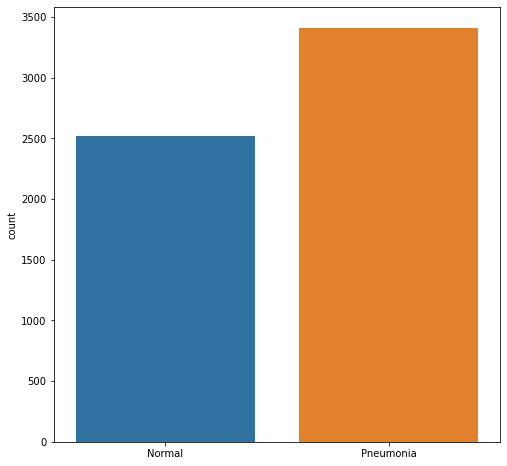

In [50]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.countplot(x=pd.Series(oversample_set.labels).map({0: 'Normal', 1: 'Pneumonia'}))

Compared to the previous training set, the number of normal x-ray images are much similar to the number of pneumonia images. 

In [63]:
## Get the array of weights for each unique class
oversample_weights= compute_class_weight(
           'balanced',
            np.unique(y_oversample),
            y_oversample)
oversample_weights

## Turn the weights into a dict with the class name as the key
oversample_weights_dict = dict(zip( np.unique(y_oversample),oversample_weights))
oversample_weights_dict

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 1. ... 1. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0.0: 1.176984126984127, 1.0: 0.8692848769050411}

In [64]:
stop_early_loss = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
stop_early_acc_binary = EarlyStopping(monitor='val_binary_accuracy', patience=7, verbose=1, restore_best_weights=True)

reduce_lr_loss=ReduceLROnPlateau(monitor= 'val_loss', patience=5, factor=.2, min_lr=.001)
reduce_lr_acc_binary=ReduceLROnPlateau(monitor= 'val_binary_accuracy', patience=5, factor=.2, min_lr=.001)

callback_loss=[stop_early_loss, reduce_lr_loss]
callback_acc_binary = [stop_early_acc_binary, reduce_lr_acc_binary]

### Iteration #1

In [73]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dropout(.5))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dropout(.5))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])
base.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 5, 5, 64)        

#### Loss

In [74]:
model1_loss=base.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 20s 396ms/step - loss: 0.6935 - binary_accuracy: 0.5040 - val_loss: 0.6940 - val_binary_accuracy: 0.4248
Epoch 2/75
47/47 [==============================] - 18s 384ms/step - loss: 0.6272 - binary_accuracy: 0.5993 - val_loss: 0.3703 - val_binary_accuracy: 0.8483
Epoch 3/75
47/47 [==============================] - 20s 424ms/step - loss: 0.3726 - binary_accuracy: 0.8463 - val_loss: 0.2805 - val_binary_accuracy: 0.8813
Epoch 4/75
47/47 [==============================] - 19s 410ms/step - loss: 0.2611 - binary_accuracy: 0.9000 - val_loss: 0.2482 - val_binary_accuracy: 0.9002
Epoch 5/75
47/47 [==============================] - 19s 409ms/step - loss: 0.2158 - binary_accuracy: 0.9216 - val_loss: 0.1945 - val_binary_accuracy: 0.9312
Epoch 6/75
47/47 [==============================] - 19s 401ms/step - loss: 0.2013 - binary_accuracy: 0.9285 - val_loss: 0.1825 - val_binary_accuracy: 0.9299
Epoch 7/75
47/47 [==============================] - 19s 40

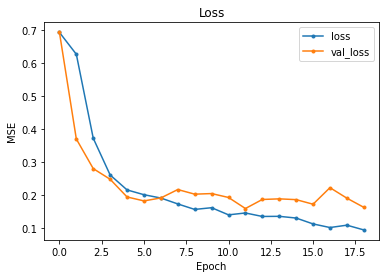

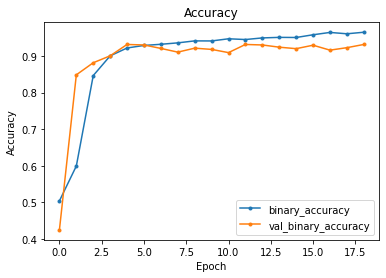

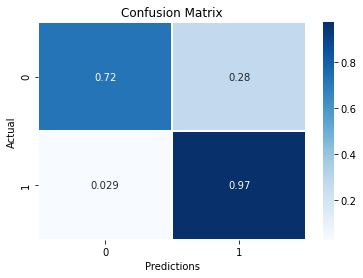

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82       188
         1.0       0.85      0.97      0.91       312

    accuracy                           0.88       500
   macro avg       0.90      0.85      0.86       500
weighted avg       0.89      0.88      0.87       500



In [75]:
model_score(model1_loss, base, X_test, y_test)

For the models that trained from the oversampled data, I have increased the max number of epochs to 75 from 30. 
And as it is clearly visible, our model is performing **MUCH** better than before with recall rate for  true positive at 97%. This shows that much of the past modeling's error were due to the lack of normal image data. 

In [68]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dropout(.5))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dropout(.5))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

#### Accuracy

In [69]:
model1_acc=base.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 20s 402ms/step - loss: 0.6933 - binary_accuracy: 0.5373 - val_loss: 0.6929 - val_binary_accuracy: 0.5752
Epoch 2/75
47/47 [==============================] - 19s 403ms/step - loss: 0.6425 - binary_accuracy: 0.5723 - val_loss: 0.4893 - val_binary_accuracy: 0.8651
Epoch 3/75
47/47 [==============================] - 19s 397ms/step - loss: 0.3424 - binary_accuracy: 0.8638 - val_loss: 0.2757 - val_binary_accuracy: 0.8813
Epoch 4/75
47/47 [==============================] - 19s 396ms/step - loss: 0.2479 - binary_accuracy: 0.9036 - val_loss: 0.2872 - val_binary_accuracy: 0.8833
Epoch 5/75
47/47 [==============================] - 19s 396ms/step - loss: 0.2315 - binary_accuracy: 0.9076 - val_loss: 0.2015 - val_binary_accuracy: 0.9164
Epoch 6/75
47/47 [==============================] - 19s 412ms/step - loss: 0.1941 - binary_accuracy: 0.9278 - val_loss: 0.1914 - val_binary_accuracy: 0.9137
Epoch 7/75
47/47 [==============================] - 19s 40

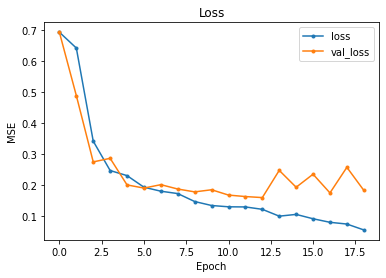

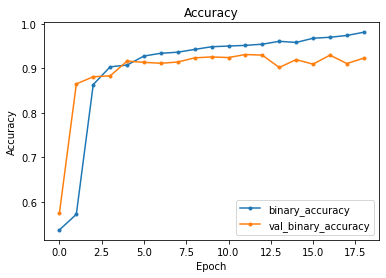

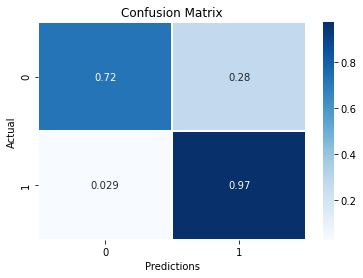

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82       188
         1.0       0.85      0.97      0.91       312

    accuracy                           0.88       500
   macro avg       0.90      0.85      0.86       500
weighted avg       0.89      0.88      0.87       500



In [76]:
model_score(model1_acc, base, X_test, y_test)

This version that uses validation accuracy as the stopping metric does not have much difference to the previous version in terms of the recall scores. Both versions have similar validation loss and validation accuracy graphs. 

### Iteration #2

In [77]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dropout(.5))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

#### Accuracy

In [78]:
model2_acc=iter_2.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 21s 435ms/step - loss: 0.6535 - binary_accuracy: 0.5863 - val_loss: 0.4025 - val_binary_accuracy: 0.8193
Epoch 2/75
47/47 [==============================] - 20s 433ms/step - loss: 0.3423 - binary_accuracy: 0.8565 - val_loss: 0.2662 - val_binary_accuracy: 0.8881
Epoch 3/75
47/47 [==============================] - 20s 430ms/step - loss: 0.2389 - binary_accuracy: 0.9056 - val_loss: 0.2091 - val_binary_accuracy: 0.9164
Epoch 4/75
47/47 [==============================] - 20s 430ms/step - loss: 0.1867 - binary_accuracy: 0.9302 - val_loss: 0.2754 - val_binary_accuracy: 0.9056
Epoch 5/75
47/47 [==============================] - 20s 436ms/step - loss: 0.1952 - binary_accuracy: 0.9245 - val_loss: 0.1791 - val_binary_accuracy: 0.9272
Epoch 6/75
47/47 [==============================] - 20s 432ms/step - loss: 0.1506 - binary_accuracy: 0.9427 - val_loss: 0.1546 - val_binary_accuracy: 0.9312
Epoch 7/75
47/47 [==============================] - 20s 43

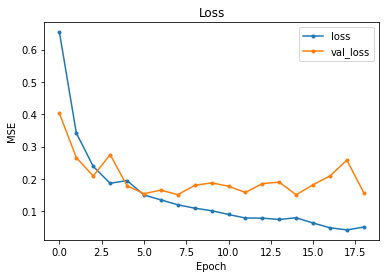

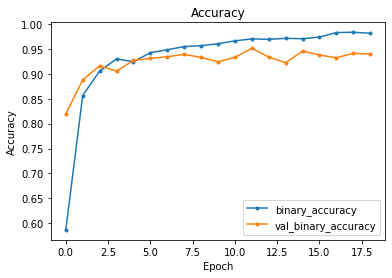

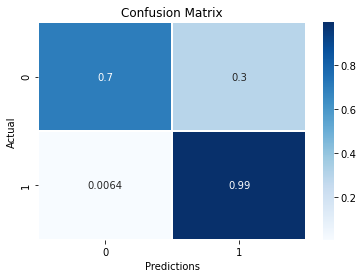

              precision    recall  f1-score   support

         0.0       0.99      0.70      0.82       188
         1.0       0.85      0.99      0.91       312

    accuracy                           0.88       500
   macro avg       0.92      0.85      0.87       500
weighted avg       0.90      0.88      0.88       500



In [79]:
model_score(model2_acc, iter_2, X_test, y_test)

This iteration did not perform much differently compared to the first iteration. Its recall score for true positive has increased by 2% and its recall score for true negative decreased by the same amount. 

In [80]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dropout(.5))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dropout(.5))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

#### Loss

In [81]:
model2_loss=iter_2.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 20s 414ms/step - loss: 0.6932 - binary_accuracy: 0.5115 - val_loss: 0.6993 - val_binary_accuracy: 0.3710
Epoch 2/75
47/47 [==============================] - 19s 408ms/step - loss: 0.5615 - binary_accuracy: 0.6814 - val_loss: 0.1382 - val_binary_accuracy: 0.9516
Epoch 3/75
47/47 [==============================] - 19s 409ms/step - loss: 0.3186 - binary_accuracy: 0.8769 - val_loss: 0.1101 - val_binary_accuracy: 0.9677
Epoch 4/75
47/47 [==============================] - 19s 411ms/step - loss: 0.2403 - binary_accuracy: 0.9110 - val_loss: 0.7204 - val_binary_accuracy: 0.7339
Epoch 5/75
47/47 [==============================] - 19s 412ms/step - loss: 0.2079 - binary_accuracy: 0.9272 - val_loss: 0.1041 - val_binary_accuracy: 0.9597
Epoch 6/75
47/47 [==============================] - 19s 410ms/step - loss: 0.1681 - binary_accuracy: 0.9418 - val_loss: 0.0921 - val_binary_accuracy: 0.9839
Epoch 7/75
47/47 [==============================] - 20s 41

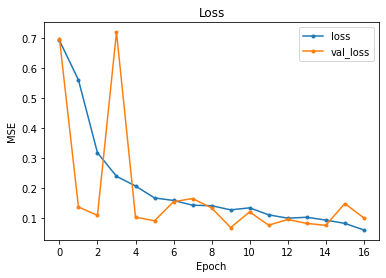

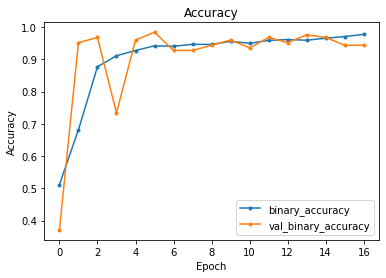

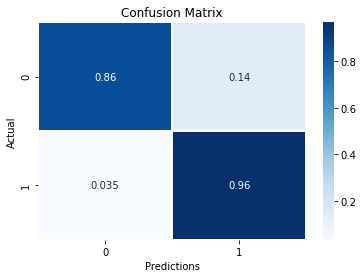

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.89       188
         1.0       0.92      0.96      0.94       312

    accuracy                           0.92       500
   macro avg       0.93      0.91      0.92       500
weighted avg       0.92      0.92      0.92       500



In [82]:
model_score(model2_loss, iter_2, X_test, y_test) 

Surprisingly, this version of the second iteration performed much better than the first version. This version uses the validation loss as the stopping metric, and while the recall score for the true positive has dropped by 3%, it could distinguish normal patients much better and its recall score improved by 16%.

### Iteration #3

In [83]:
iter3=models.Sequential()

iter3.add(Conv2D(32, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(128, (3,3), activation='relu'))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dropout(.8))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

#### Loss

In [84]:
model3_loss=iter3.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 8s 161ms/step - loss: 0.6841 - binary_accuracy: 0.5052 - val_loss: 0.6608 - val_binary_accuracy: 0.6925
Epoch 2/75
47/47 [==============================] - 7s 156ms/step - loss: 0.4871 - binary_accuracy: 0.7601 - val_loss: 0.3563 - val_binary_accuracy: 0.8227
Epoch 3/75
47/47 [==============================] - 7s 153ms/step - loss: 0.3309 - binary_accuracy: 0.8742 - val_loss: 0.2306 - val_binary_accuracy: 0.9157
Epoch 4/75
47/47 [==============================] - 7s 152ms/step - loss: 0.2824 - binary_accuracy: 0.8980 - val_loss: 0.4924 - val_binary_accuracy: 0.7916
Epoch 5/75
47/47 [==============================] - 7s 153ms/step - loss: 0.2802 - binary_accuracy: 0.9009 - val_loss: 0.2092 - val_binary_accuracy: 0.9211
Epoch 6/75
47/47 [==============================] - 7s 153ms/step - loss: 0.2280 - binary_accuracy: 0.9238 - val_loss: 0.2647 - val_binary_accuracy: 0.8793
Epoch 7/75
47/47 [==============================] - 7s 152ms/ste

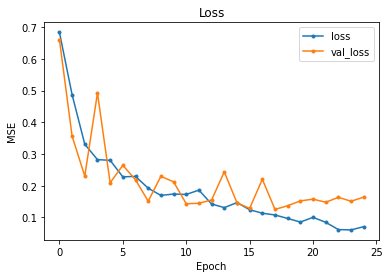

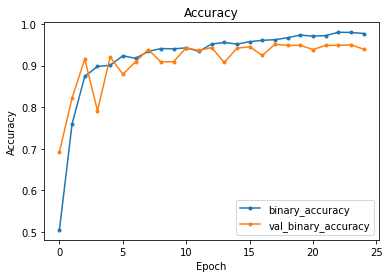

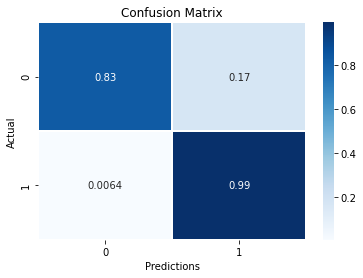

              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90       188
         1.0       0.91      0.99      0.95       312

    accuracy                           0.93       500
   macro avg       0.95      0.91      0.92       500
weighted avg       0.94      0.93      0.93       500



In [85]:
model_score(model3_loss,iter3, X_test, y_test) 


Again, not much change from the previous iteration. But still better than the first iteration.

#### Accuracy

In [86]:
iter3=models.Sequential()

iter3.add(Conv2D(32, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(128, (3,3), activation='relu'))
iter3.add(Conv2D(64, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dropout(.8))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [87]:
model3_acc=iter3.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 8s 153ms/step - loss: 0.6715 - binary_accuracy: 0.5487 - val_loss: 0.5481 - val_binary_accuracy: 0.7808
Epoch 2/75
47/47 [==============================] - 7s 149ms/step - loss: 0.4712 - binary_accuracy: 0.7851 - val_loss: 0.3734 - val_binary_accuracy: 0.8456
Epoch 3/75
47/47 [==============================] - 7s 150ms/step - loss: 0.3565 - binary_accuracy: 0.8635 - val_loss: 0.2303 - val_binary_accuracy: 0.9042
Epoch 4/75
47/47 [==============================] - 7s 149ms/step - loss: 0.3074 - binary_accuracy: 0.8857 - val_loss: 0.2186 - val_binary_accuracy: 0.9016
Epoch 5/75
47/47 [==============================] - 7s 150ms/step - loss: 0.2827 - binary_accuracy: 0.8950 - val_loss: 0.2044 - val_binary_accuracy: 0.9083
Epoch 6/75
47/47 [==============================] - 7s 150ms/step - loss: 0.2482 - binary_accuracy: 0.9098 - val_loss: 0.2345 - val_binary_accuracy: 0.9096
Epoch 7/75
47/47 [==============================] - 7s 152ms/ste

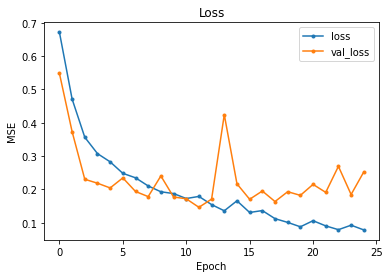

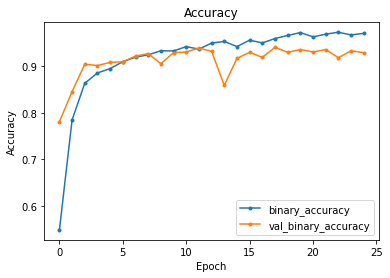

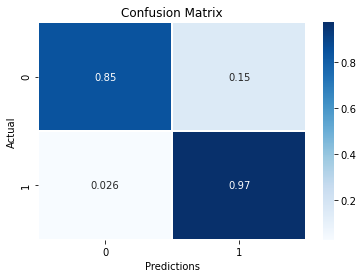

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90       188
         1.0       0.91      0.97      0.94       312

    accuracy                           0.93       500
   macro avg       0.93      0.91      0.92       500
weighted avg       0.93      0.93      0.93       500



In [88]:
model_score(model3_acc,iter3, X_test, y_test) #32 64 128 64 32 no dense 32

There seems to be a trend from the second version of the second iteration where a the in recall score for either the true positive or true negative is reflected on its counter part by the same amount, and their sum always equals 1.82.

### Iteration #4

In [89]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dropout(.3))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

#### Accuracy

In [90]:
model4_acc=iter4.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 3s 61ms/step - loss: 0.4604 - binary_accuracy: 0.7864 - val_loss: 0.2802 - val_binary_accuracy: 0.8780
Epoch 2/75
47/47 [==============================] - 3s 62ms/step - loss: 0.2732 - binary_accuracy: 0.8886 - val_loss: 0.2628 - val_binary_accuracy: 0.8793
Epoch 3/75
47/47 [==============================] - 3s 59ms/step - loss: 0.2243 - binary_accuracy: 0.9100 - val_loss: 0.2354 - val_binary_accuracy: 0.9063
Epoch 4/75
47/47 [==============================] - 3s 59ms/step - loss: 0.2146 - binary_accuracy: 0.9145 - val_loss: 0.2258 - val_binary_accuracy: 0.9036
Epoch 5/75
47/47 [==============================] - 3s 59ms/step - loss: 0.1880 - binary_accuracy: 0.9263 - val_loss: 0.2075 - val_binary_accuracy: 0.9076
Epoch 6/75
47/47 [==============================] - 3s 58ms/step - loss: 0.1792 - binary_accuracy: 0.9324 - val_loss: 0.1995 - val_binary_accuracy: 0.9171
Epoch 7/75
47/47 [==============================] - 3s 58ms/step - los

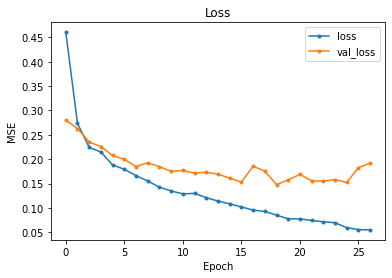

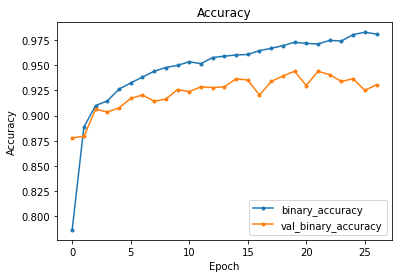

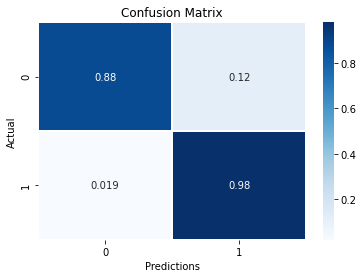

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       188
         1.0       0.93      0.98      0.96       312

    accuracy                           0.94       500
   macro avg       0.95      0.93      0.94       500
weighted avg       0.95      0.94      0.94       500



In [91]:
model_score(model4_acc, iter4, X_test, y_test)#droput= .3

This is where we saw the biggest improvement. We have a very high recall score for the true positive and a relatively high recall score for the true negative. Unfortunately, the validation loss and validation accuracy graphs seem to not fit as well as some of the previous iterations. 

In [92]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dropout(.3))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

#### Loss

In [93]:
model4_loss=iter4.fit(X_oversample, y_oversample , epochs=75, batch_size=batch_batch, validation_data=(X_os_val, y_os_val), 
                  class_weight=oversample_weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/75
47/47 [==============================] - 4s 67ms/step - loss: 0.5656 - binary_accuracy: 0.7014 - val_loss: 0.4120 - val_binary_accuracy: 0.7707
Epoch 2/75
47/47 [==============================] - 3s 60ms/step - loss: 0.3151 - binary_accuracy: 0.8687 - val_loss: 0.2598 - val_binary_accuracy: 0.8860
Epoch 3/75
47/47 [==============================] - 3s 59ms/step - loss: 0.2518 - binary_accuracy: 0.9002 - val_loss: 0.2281 - val_binary_accuracy: 0.9016
Epoch 4/75
47/47 [==============================] - 3s 60ms/step - loss: 0.2361 - binary_accuracy: 0.9063 - val_loss: 0.2186 - val_binary_accuracy: 0.9016
Epoch 5/75
47/47 [==============================] - 3s 60ms/step - loss: 0.2110 - binary_accuracy: 0.9162 - val_loss: 0.2125 - val_binary_accuracy: 0.9063
Epoch 6/75
47/47 [==============================] - 3s 60ms/step - loss: 0.1989 - binary_accuracy: 0.9245 - val_loss: 0.2154 - val_binary_accuracy: 0.9090
Epoch 7/75
47/47 [==============================] - 3s 60ms/step - los

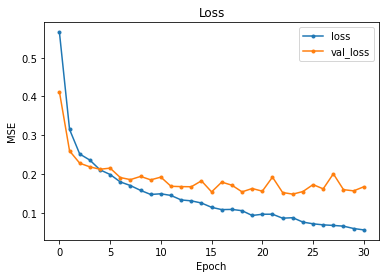

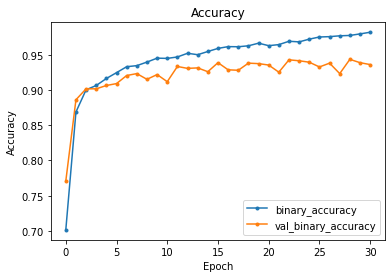

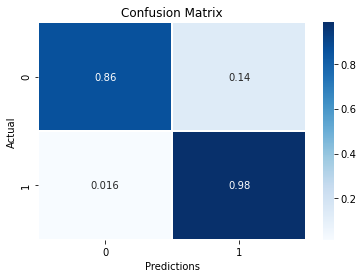

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91       188
         1.0       0.92      0.98      0.95       312

    accuracy                           0.94       500
   macro avg       0.95      0.92      0.93       500
weighted avg       0.94      0.94      0.94       500



In [94]:
model_score(model4_loss, iter4, X_test, y_test) #droput =.3

Here we see a slight decrease in the recall score for the true negative while the recall score for the true positive stayed the same. However, the validation accuracy and loss graphs fit slightly better than the previous version of this iteration. 

## Conclusion

### Model Recommendation

For each iteration of the models, there were two versions; one that looked at the validation accuracy and one that looked at validation accuracy as the main determinant in setting the stopping point for the neural network.
<br>
I would recommend using the models trained using the oversampled data. While many of them performed very well, I believe the fourth model that uses validation accuracy as the stopping metric performed the best with a recall score of 98% for the true positive and 88% for the true negative. Unlike the models that did not train with the oversampled data, these models were able to achieve high recall score for the true positives without sacrificing the recall score for the true negatives. When the first four models were able to achieve similar recall scores for both the true positives and true negatives, the recall scores remained in the low to mid 80s, but after oversampling, the models were able to achieve recall scores of high 80s and 90s. <br>
However, it should be noted that while the model is now able to diagnose pneumonia through x-ray images much better than before, a doctor should still need to confirm its results. For this, I would recommend that the doctor examine x-ray images that the model has labeled to be a pneumonia patient since 12% of normal patients are labeled as pneumonia patients. Such misdiagnosis could lead to the patient having to pay for unnecessary treatment, and in worse cases create complications that rose from the treatment.


### Future Work
For future work, I would like to improve the model's prediction on false positives. While it could discern 88% of normal patients as normal, the rate can still be improved upon. Possible solutions may be:
 - Format/align the pictures to show just the thorax region to remove possible mis-detections
 - Distinguish sections such as the heart to remove possible mis-detections
 - Separate images of bacterial pneumonia and viral pneumonia for training for ease of diagnosis since they require different treatments. 
 
### Final Thoughts
Overall, the project was as challenging as it was insightful. After visiting an A.I. expo and seeing how computer vision was being used to diagnose cancer and how the A.I. that they had created were finding previously unknown indications that could lead to an early diagnosis of breast cancer. The year before this, the doctors had found a tumor-like tissue in her uterus during an annual check up. Fortunately it turned out to be a benign form, but we were worried that she could develop breast cancer as uterine tumors could lead to or were early signs of breast cancer. Because of this previous incident, the use of A.I. in diagnosing cancer spoke to me in a different way, and I became much interested in general A.I. and the use of A.I. in the medical field. Though this project is miles behind compared to what I had seen in the expo, it was meaningful nonetheless.